# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Hydro Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\hydro_production_dataset.csv')

data.head()

,Country,Date,Value,Precipitation
0,Australia,2023-03-01,1215.8041,0.080641
1,Australia,2023-02-01,942.5558,0.127869
2,Australia,2023-01-01,1190.7296,0.159242
3,Australia,2022-12-01,1110.1523,0.105662
4,Australia,2022-11-01,1397.5839,0.073524


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

hydro_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'Hydro' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Precipitation']
    ]
    
    # Store the filtered data in the dictionary
    hydro_production_data[country] = country_energy_production.reset_index(drop=True)

hydro_production_data['Canada']

,Date,Value,Precipitation
0,2023-03-01,36167.1401,0.038109
1,2023-02-01,35371.5656,0.050854
2,2023-01-01,39787.1108,0.051570
3,2022-12-01,38808.9988,0.069082
4,2022-11-01,32724.8633,0.071994
...,...,...,...
154,2010-05-01,26455.2440,0.074074
155,2010-04-01,28243.7380,0.054558
156,2010-03-01,32408.9280,0.042638
157,2010-02-01,33436.8180,0.037283


# Resample to daily data

In [4]:
# hypro_production_data
for country_data in hydro_production_data:
    
    # set time as the index
    hydro_production_data[country_data]['Date'] = pd.to_datetime(hydro_production_data[country_data]['Date'])
    hydro_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    hydro_production_data[country_data]['Value'] = (hydro_production_data[country_data]['Value']/
                                                    hydro_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = hydro_production_data[country_data].resample('D').interpolate('linear')
    hydro_production_data[country_data] = daily_data
    
hydro_production_data['Canada']

,Value,Precipitation
Date,,
2010-01-01,1222.103194,0.054261
2010-01-02,1221.202190,0.053713
2010-01-03,1220.301186,0.053165
2010-01-04,1219.400182,0.052618
2010-01-05,1218.499178,0.052070
...,...,...
2023-02-25,1180.480262,0.039930
2023-02-26,1177.030681,0.039475
2023-02-27,1173.581100,0.039019


## Split Train and Test Data

In [61]:
data = hydro_production_data['Canada']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date][['Value']], data[split_date:][['Value']]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                  Value
Date                   
2010-01-01  1222.103194
2010-01-02  1221.202190
2010-01-03  1220.301186
2010-01-04  1219.400182
2010-01-05  1218.499178
(4019, 1)

                  Value
Date                   
2021-01-01  1299.733232
2021-01-02  1299.996850
2021-01-03  1300.260468
2021-01-04  1300.524086
2021-01-05  1300.787704
(790, 1)


## Univariate - ARIMA - Daily

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,1)(0,1,0)[365]
#### Figure below show the result from R:
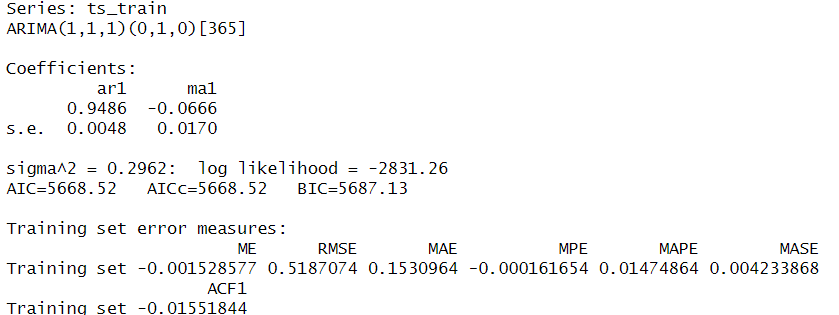

In [59]:
pip install rpy2

Note: you may need to restart the kernel to use updated packages.Collecting rpy2
     ---------------------------------------- 0.0/218.8 kB ? eta -:--:--
     ------------------------------------- 218.8/218.8 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for tzlocal from https://files.pythonhosted.org/packages/84/d2/730a87f0dbf184760394a85088d0d2366a5a8a32bc32ffd869a83f1de854/tzlocal-5.0.1-py3-none-any.whl.metadata
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
Using cached tzlocal-5.0.1-py3-none-any.whl (20 kB)
  Created wheel for rpy2: filename=rpy2-3.5.13-py3-none-any.whl size=220527 sha256=7311bac222b553a1b8c9d873fa1d022d545b799bcb7

In [66]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
can_hydro_arima_model = r_load("F:\APU\FYP\SEM 2\Report Doc\R script\can_hydro_arima_model.rds")

In [68]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(can_hydro_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test.values))
mse = mean_squared_error(predictions.rx('mean')[0], test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  102.24402488855733
Mean Squared Error:  12317.845479936695
Root Mean Squared Error:  110.98578954053846


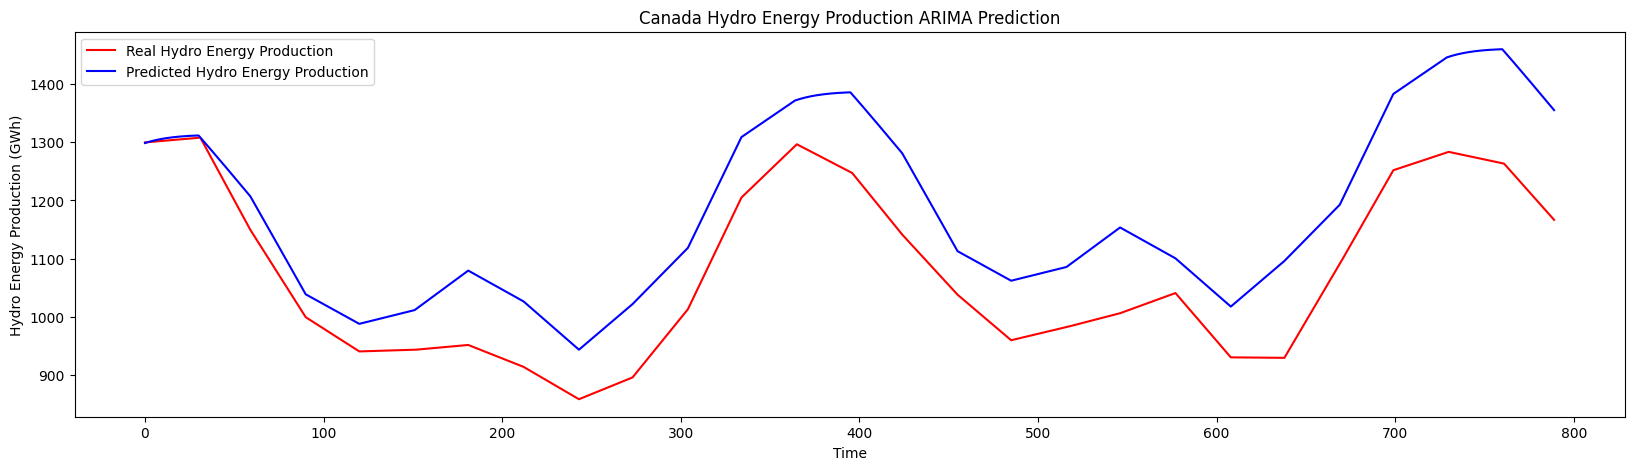

In [70]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Canada Hydro Energy Production ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy Production (GWh)')
plt.legend()
plt.show()

## Univariate - SVR - Daily

In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [71]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data to fit
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(3654, 365) (3654,)


In [72]:
# Build and Train the SVM Model
can_daily_svr = SVR(kernel='linear',gamma=0.5, C=10, epsilon = 0.01)
can_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')

In [73]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Hydro Energy Production
svr_y_pred = can_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [74]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  2.156072001666649
Mean Squared Error:  7.624815171962846
Root Mean Squared Error:  2.7613067870055374


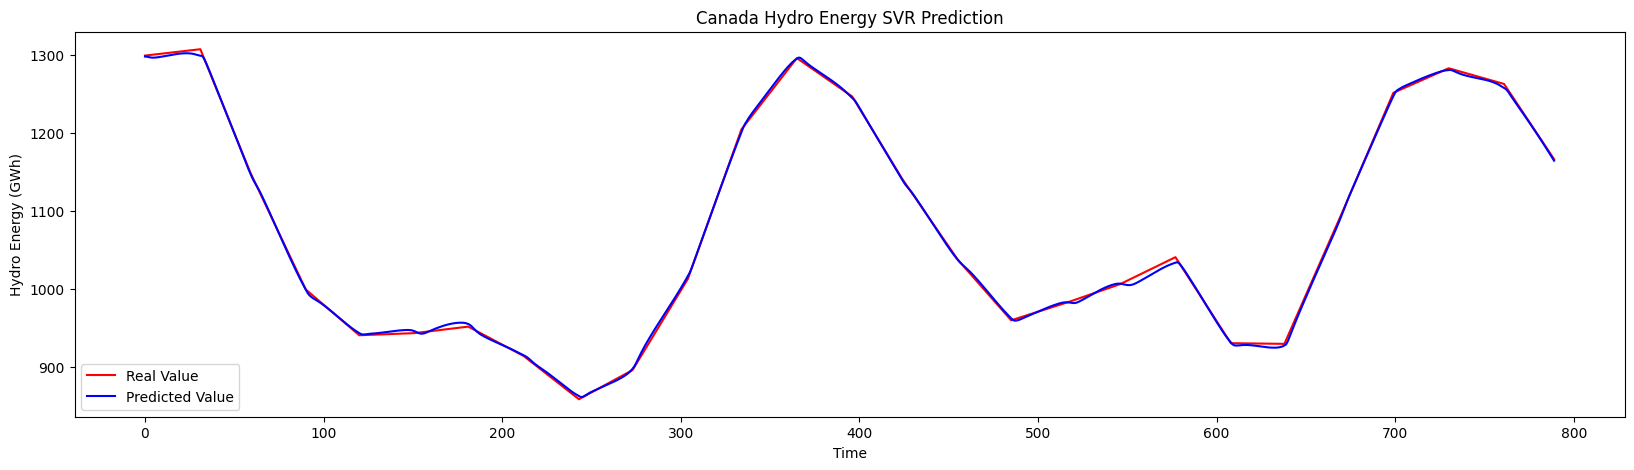

In [75]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('Canada Hydro Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate ANN - Daily

In [12]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

In [13]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test.values, time_steps)

X_train.shape

(3654, 365, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

# Create the model
can_daily_ann = Sequential()
can_daily_ann.add(Dense(84, activation='tanh', input_shape=(365,)))
can_daily_ann.add(Dropout(0.2))
can_daily_ann.add(Dense(1, activation='linear'))

can_daily_ann.compile(optimizer='adam', loss='mean_squared_error')

can_daily_ann.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
229/229 [==============================] - 1s 1ms/step - loss: 0.1086
Epoch 2/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0195
Epoch 3/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 4/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 5/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 6/100
229/229 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 7/100
229/229 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 8/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0060
Epoch 9/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 10/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 11/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0030
Epoch 12/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 13/100


In [44]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

ann_y_pred = can_daily_ann.predict(X_test)
ann_y_pred = sc.inverse_transform(ann_y_pred)

print("Mean Absolute Error: ", mean_absolute_error(ann_y_pred, test.values))
mse = mean_squared_error(ann_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

25/25 [==============================] - 4s 39ms/step
Mean Absolute Error:  4.451785338199992
Mean Squared Error:  34.47761220917881
Root Mean Squared Error:  5.871763977645799


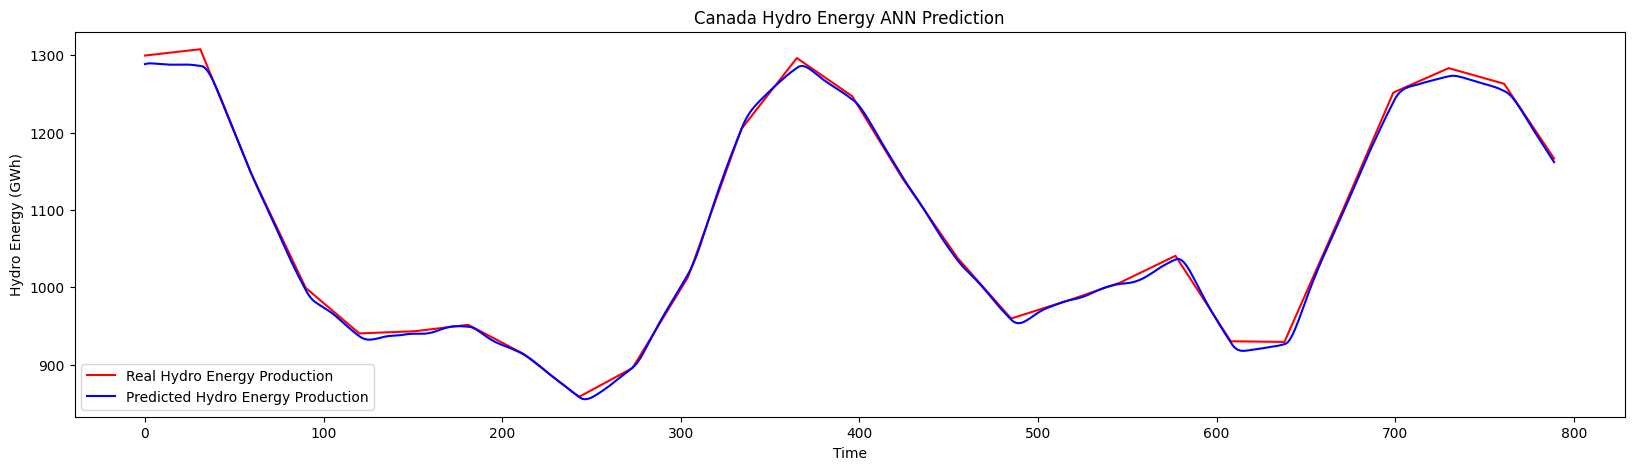

In [45]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(ann_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Canada Hydro Energy ANN Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [17]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.85005279]
 [0.8484521 ]
 [0.84685141]
 ...
 [0.98052085]
 [0.9842441 ]
 [0.98796736]]
(4019, 1)


In [18]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-365:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
print(X_train)
X_train.shape

[[0.85005279 0.8484521  0.84685141 ... 0.83175578 0.83527881 0.83880183]
 [0.8484521  0.84685141 0.84525073 ... 0.83527881 0.83880183 0.84232486]
 [0.84685141 0.84525073 0.84365004 ... 0.83880183 0.84232486 0.84183455]
 ...
 [0.89078843 0.89234965 0.8921202  ... 0.96935109 0.97307434 0.9767976 ]
 [0.89234965 0.8921202  0.89189074 ... 0.97307434 0.9767976  0.98052085]
 [0.8921202  0.89189074 0.89166129 ... 0.9767976  0.98052085 0.9842441 ]]


(3654, 365)

In [20]:
print(y_train)
y_train.shape

[0.84232486 0.84183455 0.84134423 ... 0.98052085 0.9842441  0.98796736]


(3654,)

In [21]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [23]:
# Initialising the RNN
can_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
can_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
can_daily_uni_lstm.add(Dropout(0.2))

can_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
can_daily_uni_lstm.add(Dropout(0.2))

can_daily_uni_lstm.add(LSTM(units = 64))
can_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
can_daily_uni_lstm.add(Dense(units = 1))

In [24]:
# Compiling the RNN
can_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
can_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
115/115 [==============================] - 52s 392ms/step - loss: 0.0154
Epoch 2/100
115/115 [==============================] - 41s 356ms/step - loss: 0.0038
Epoch 3/100
115/115 [==============================] - 40s 344ms/step - loss: 0.0036
Epoch 4/100
115/115 [==============================] - 40s 347ms/step - loss: 0.0024
Epoch 5/100
115/115 [==============================] - 42s 368ms/step - loss: 0.0026
Epoch 6/100
115/115 [==============================] - 48s 415ms/step - loss: 0.0025
Epoch 7/100
115/115 [==============================] - 45s 389ms/step - loss: 0.0021
Epoch 8/100
115/115 [==============================] - 61s 527ms/step - loss: 0.0020
Epoch 9/100
115/115 [==============================] - 63s 544ms/step - loss: 0.0018
Epoch 10/100
115/115 [==============================] - 57s 491ms/step - loss: 0.0017
Epoch 11/100
115/115 [==============================] - 59s 513ms/step - loss: 0.0016
Epoch 12/100
115/115 [==============================] - 61s 533

Epoch 93/100
115/115 [==============================] - 108s 942ms/step - loss: 3.2139e-04
Epoch 94/100
115/115 [==============================] - 111s 964ms/step - loss: 3.3415e-04
Epoch 95/100
115/115 [==============================] - 109s 949ms/step - loss: 3.4155e-04
Epoch 96/100
115/115 [==============================] - 112s 969ms/step - loss: 3.6944e-04
Epoch 97/100
115/115 [==============================] - 110s 957ms/step - loss: 4.0159e-04
Epoch 98/100
115/115 [==============================] - 114s 997ms/step - loss: 3.3927e-04
Epoch 99/100
115/115 [==============================] - 113s 982ms/step - loss: 3.4665e-04
Epoch 100/100
115/115 [==============================] - 108s 941ms/step - loss: 3.3782e-04


In [25]:
test[['Value']].shape

(790, 1)

In [46]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = can_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 10s 266ms/step


In [47]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test.values))
mse = mean_squared_error(uni_lstm_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  1.8030793484520669
Mean Squared Error:  7.433988484557129
Root Mean Squared Error:  2.7265341524648337


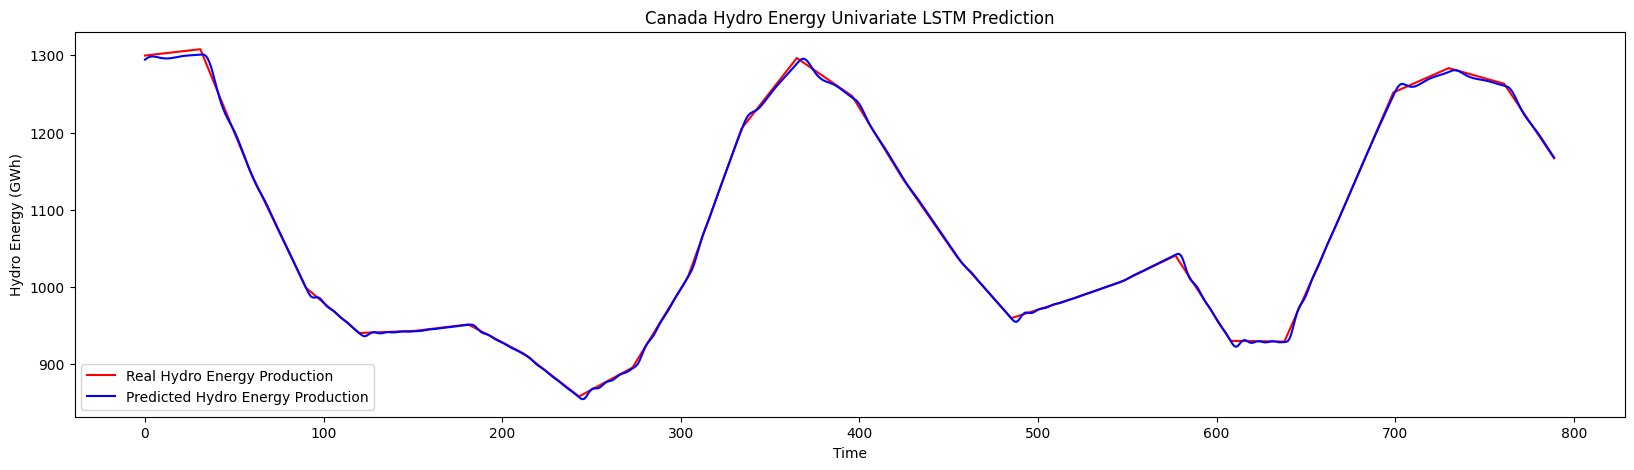

In [48]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('Canada Hydro Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [29]:
data = hydro_production_data['Canada']

data.shape

(4808, 2)

In [51]:
X = data[['Precipitation', 'Value']]
y = data[['Value']]

X.head()

,Precipitation,Value
Date,,
2010-01-01,0.054261,1222.103194
2010-01-02,0.053713,1221.202190
2010-01-03,0.053165,1220.301186
2010-01-04,0.052618,1219.400182
2010-01-05,0.052070,1218.499178


In [52]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [53]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [33]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(4019, 2)
(790, 2)

(4019, 1)
(790, 1)


In [34]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

print(X_train1.shape)

(3654, 365, 2)


In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

can_daily_multi_lstm = Sequential()
can_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
can_daily_multi_lstm.add(Dropout(0.2))
can_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
can_daily_multi_lstm.add(Dropout(0.2))
can_daily_multi_lstm.add(LSTM(units = 64))
can_daily_multi_lstm.add(Dropout(0.2))
can_daily_multi_lstm.add(Dense(1))

In [36]:
can_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

can_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 207s 884ms/step - loss: 0.0216
Epoch 2/100
115/115 [==============================] - 101s 881ms/step - loss: 0.0042
Epoch 3/100
115/115 [==============================] - 108s 936ms/step - loss: 0.0031
Epoch 4/100
115/115 [==============================] - 103s 897ms/step - loss: 0.0029
Epoch 5/100
115/115 [==============================] - 101s 879ms/step - loss: 0.0030
Epoch 6/100
115/115 [==============================] - 106s 925ms/step - loss: 0.0023
Epoch 7/100
115/115 [==============================] - 103s 897ms/step - loss: 0.0023
Epoch 8/100
115/115 [==============================] - 89s 772ms/step - loss: 0.0019
Epoch 9/100
115/115 [==============================] - 89s 773ms/step - loss: 0.0019
Epoch 10/100
115/115 [==============================] - 109s 951ms/step - loss: 0.0020
Epoch 11/100
115/115 [==============================] - 108s 938ms/step - loss: 0.0017
Epoch 12/100
115/115 [==============================] 

115/115 [==============================] - 86s 749ms/step - loss: 3.4990e-04
Epoch 94/100
115/115 [==============================] - 85s 736ms/step - loss: 3.5244e-04
Epoch 95/100
115/115 [==============================] - 78s 676ms/step - loss: 3.6420e-04
Epoch 96/100
115/115 [==============================] - 78s 674ms/step - loss: 3.5962e-04
Epoch 97/100
115/115 [==============================] - 84s 734ms/step - loss: 3.7023e-04
Epoch 98/100
115/115 [==============================] - 79s 690ms/step - loss: 3.9641e-04
Epoch 99/100
115/115 [==============================] - 83s 720ms/step - loss: 3.5021e-04
Epoch 100/100
115/115 [==============================] - 90s 782ms/step - loss: 3.3991e-04


In [76]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)

X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))

multi_lstm_y_pred = can_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)

25/25 [==============================] - 10s 141ms/step


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(predicted_value, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4.161076991372907
Mean Squared Error:  28.27059386444777
Root Mean Squared Error:  5.317009861232887


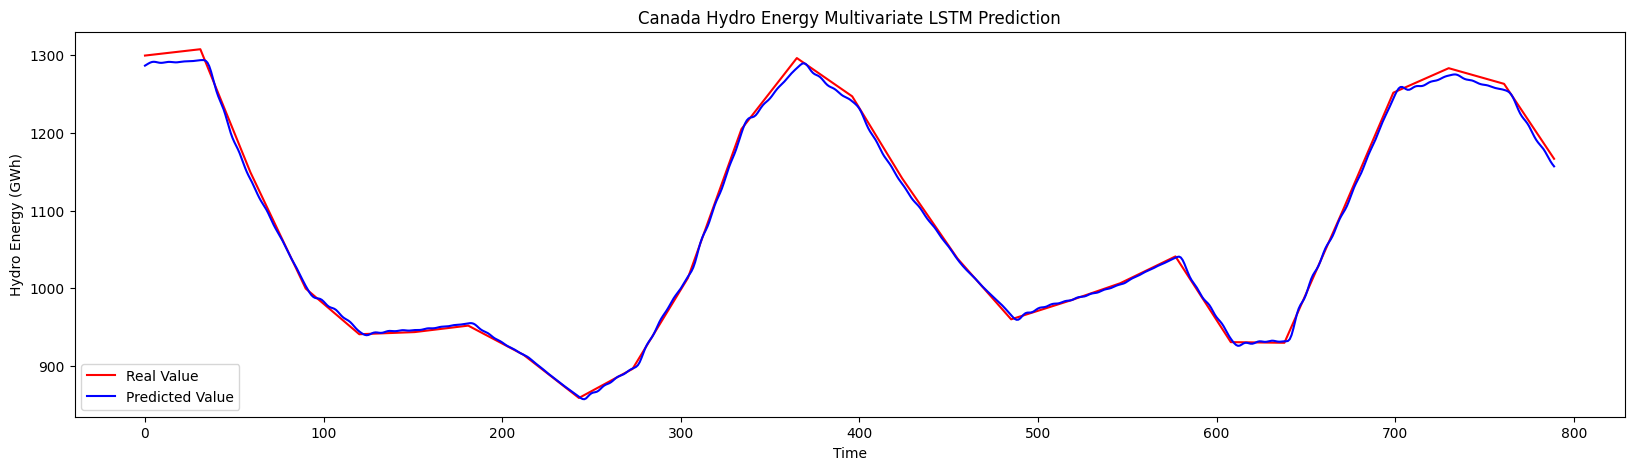

In [56]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('Canada Hydro Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Overview

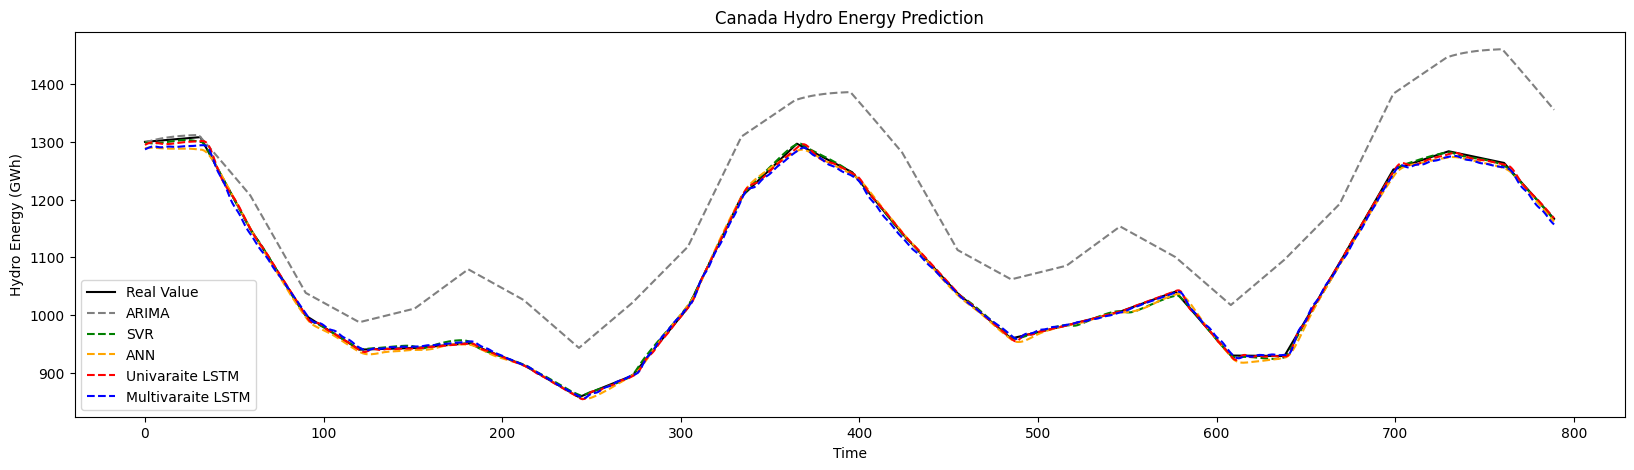

In [77]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(ann_y_pred, color='orange', linestyle='--', label='ANN')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('Canada Hydro Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [40]:
can_daily_uni_lstm.save('can_hydro_best_uni_lstm.h5')

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
